In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def give_sig_weights(monopole_df):
    file = uproot.open("/home/zhonghua/data/exposure_Gaisser.root")
    h1 = file["h1"]
    h2 = file["h2"]
    # 获取直方图的所有数据
    values = h1.values()        # bin内容（纵坐标）
    h2_values = h2.values()        # bin内容（纵坐标）
    edges = h1.axis().edges()   # bin边界（横坐标）
    h2_edges = h2.axis().edges()   # bin边界（横坐标）
    centers = h1.axis().centers()  # bin中心
    h2_centers = h2.axis().centers()  # bin中心

    values = np.array(h1.values())
    edges = np.array(h1.axis().edges())
    centers = np.array(h1.axis().centers())
    S=np.pi * 1000**2
    parker=1e-15 * 1e4 
    nums=[]
    for i, theta in enumerate(centers):
        cosine_theta = np.cos(np.deg2rad(theta))
        area = S * cosine_theta
        exposure = values[i] * area
        num_i = exposure * parker
        nums.append(num_i)

    weights=[num_i/251000/h2_values[i]/86400 for i, num_i in enumerate(nums)]
    theta_degrees = monopole_df["theta"] * 180 / np.pi
    monopole_weights = []
    for theta in theta_degrees:
        if theta > max(centers) or theta < 0:
            weight = weights[-1] if theta > max(centers) else 0
        else:
            bin_id = np.digitize(theta, edges) - 1
            weight = weights[bin_id]
        monopole_weights.append(weight)
  
    monopole_df["weight"] = monopole_weights
    # print(f"======> Total expected monopole events after weighting: {monopole_df['weight'].sum()} ======")
    return monopole_df

def give_bkg_mc_weights_gaisser(pr_df: pd.DataFrame):
    rootfile = "/home/zhonghua/data/exposure_Gaisser.root"
    with uproot.open(rootfile) as f:
        hWeight = f["hWeight"]
        edges_E = hWeight.axes[0].edges()  # Energy bin edges
        edges_Zen = hWeight.axes[1].edges()  # Zenith bin edges
        weights_2d = hWeight.values()

    def add_weights(trueE, rec_zenith, weights_2d):
        trueE=np.log10(trueE/1e3)
        rec_zenith=180/np.pi*rec_zenith
        bin_idx_E = np.digitize(trueE, edges_E) - 1
        bin_idx_Zen = np.digitize(rec_zenith, edges_Zen) - 1
        if bin_idx_E >= weights_2d.shape[0]:
            bin_idx_E = weights_2d.shape[0] - 1
        if bin_idx_Zen >= weights_2d.shape[1]:
            bin_idx_Zen = weights_2d.shape[1] - 1
        return weights_2d[bin_idx_E, bin_idx_Zen]
    
    pr_df['gaisser_weight']=pr_df.apply(lambda row: add_weights(row['trueE'],row['rec_theta'],weights_2d),axis=1)
    pr_df['gaisser_weight']=pr_df['gaisser_weight']/86400
    # print(f"======> Total expected background MC events after weighting: {pr_df['gaisser_weight'].sum()} ======")
    return pr_df

def give_bkg_mc_weights_horandel(pr_df: pd.DataFrame):
    rootfile = "/home/zhonghua/data/exposure_Horandel.root"
    with uproot.open(rootfile) as f:
        hWeight = f["hWeight"]
        edges_E = hWeight.axes[0].edges()  # Energy bin edges
        edges_Zen = hWeight.axes[1].edges()  # Zenith bin edges
        weights_2d = hWeight.values()

    def add_weights(trueE, rec_zenith, weights_2d):
        trueE=np.log10(trueE/1e3)
        rec_zenith=180/np.pi*rec_zenith
        bin_idx_E = np.digitize(trueE, edges_E) - 1
        bin_idx_Zen = np.digitize(rec_zenith, edges_Zen) - 1
        if bin_idx_E >= weights_2d.shape[0]:
            bin_idx_E = weights_2d.shape[0] - 1
        if bin_idx_Zen >= weights_2d.shape[1]:
            bin_idx_Zen = weights_2d.shape[1] - 1
        return weights_2d[bin_idx_E, bin_idx_Zen]
    
    pr_df['horandel_weight']=pr_df.apply(lambda row: add_weights(row['trueE'],row['rec_theta'],weights_2d),axis=1)
    pr_df['horandel_weight']=pr_df['horandel_weight']/86400
    # print(f"======> Total expected background MC events after weighting: {pr_df['horandel_weight'].sum()} ======")
    return pr_df

def give_exp_weights(exp_df, Ndays):
    exp_df['weight'] = np.ones(len(exp_df)) / Ndays / 86400
    # print(f"======> Total expected exposure events after weighting: {exp_df['weight'].sum()} ======")
    return exp_df

r_low=260
r_high=480
theta_low=0
theta_high=40 / 180.0 * np.pi

Rmean_low=25
Rmean_high=60
Eage_low=0.8
Eage_high=1.6
R_ue_high=-5.0
log10TeV_low=1.8629710674285889
log10TeV_high=2.2981839179992676

def load_allweight_model():
    def open_file(file_name):
        with uproot.open(file_name) as file:
            tree = file["Rec"]
            branches_to_read = ["E", "theta","phi","corex","corey","rec_x","rec_y","rec_theta","rec_phi","rec_Eage","Redge","NpE3","NuM1","NuM2","NuM3","NuW3","weightGaisser","weightHorandol"]
            df = tree.arrays(branches_to_read, library="pd")
            all_weights_gaisser = df['weightGaisser'].sum()
            all_weights_horandel = df['weightHorandol'].sum()
            print(file_name)
            print("     Entries:", tree.num_entries)
            print("     Total weights Gaisser:", all_weights_gaisser)
            print("     Total weights Horandel:", all_weights_horandel)

            rec_Eage=df['rec_Eage'].values
            rec_theta=df['rec_theta'].values
            NuW3=df['NuW3'].values
            rec_x=df['rec_x'].values
            rec_y=df['rec_y'].values
            r=np.sqrt(rec_x**2+rec_y**2)
            df['rec_r']=r
            cuts_indices = (rec_Eage > Eage_low) & (rec_Eage < Eage_high) & \
                            (r > r_low) & (r < r_high) & \
                            (rec_theta > theta_low) & (rec_theta < theta_high) & \
                            (NuW3 > 0)
            df_cut = df[cuts_indices].copy() 
            
            df_cut["R_ue"]=np.log10((1e-4+df_cut["NuM2"])/(df_cut["NpE3"]+1))
            print(f"     Entries after cut: {df_cut.shape[0]}")
            del df
            return df_cut
        

    def energy_correction(df: pd.DataFrame):
        theta=df["rec_theta"].values
        # df["NuW3"]  theta 作为输入
        log10_NuW3 = np.log10(df["NuW3"].values)
        feature_data = np.column_stack((log10_NuW3, theta))
        corrected_energy = model.predict(feature_data)
        df["recE"]=corrected_energy  # log10(TeV)
        # 筛选
        df_new=df[(df["recE"]>log10TeV_low) & (df["recE"]<log10TeV_high)]
        print(f" cut weight Gaisser sum: {df_new['weightGaisser'].sum()}")
        print(f" cut weight Horandel sum: {df_new['weightHorandol'].sum()}")
        del df
        return df_new


    from xgboost import XGBRegressor
    model = XGBRegressor()
    model.load_model("/home/zhonghua/Filt_Event/recE/models/energy_correction_xgb_NuW3_8-12_higher.json")
    proton_df_QF = open_file("/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Proton_addweight_rho_2.5e13_5.0e17_V3.root")
    proton_df_QF=energy_correction(proton_df_QF)

    QF_allweights_gaisser=proton_df_QF['weightGaisser'].sum()
    QF_allweights_horandel=proton_df_QF['weightHorandol'].sum()

    return QF_allweights_gaisser,QF_allweights_horandel

QF_allweights_gaisser, QF_allweights_horandel = load_allweight_model()

def filter_dataset_optimized(npz_file, output_file=None, mc=True, R_mean_cut=True, is_csv=False, radius_cut=True):
    print("--------------------------------------------------")
    # param_names=["label","gaisser_weight",
    #                 "R_ue", "R_mean", "Eage",
    #                 "recE", "rec_x", "rec_y", "rec_theta", "rec_phi", 
    #                 "trueE", "NuW2", "NpE3", "NuM1", "core_x","core_y","theta"]
    if radius_cut is False:
        dr_low=0
        theta_low=0
        theta_high=70 / 180.0 * np.pi
    else:
        r_low=260
        r_high=480  
        theta_low=0
        theta_high=40 / 180.0 * np.pi

    if not is_csv:
        data = np.load(npz_file, allow_pickle=True)
        params_df = pd.DataFrame(data["params"], columns=data["param_names"])
    else:
        params_df = pd.read_csv(npz_file)
    initial_count = len(params_df)
    current_mask = np.ones(initial_count, dtype=bool)
    
    # asarray re ensure float dtype for calculations
    recE = np.asarray(params_df["recE"].values, dtype=float)
    R_ue = np.asarray(params_df["R_ue"].values, dtype=float)
    R_mean = np.asarray(params_df["R_mean"].values, dtype=float)
    Eage = np.asarray(params_df["Eage"].values, dtype=float)
    rec_theta = np.asarray(params_df["rec_theta"].values, dtype=float)
    rec_phi = np.asarray(params_df["rec_phi"].values, dtype=float)
    rec_x = np.asarray(params_df["rec_x"].values, dtype=float)
    rec_y = np.asarray(params_df["rec_y"].values, dtype=float)
    r = np.sqrt(rec_x**2 + rec_y**2)    
    dr = np.asarray(params_df["dr"].values, dtype=float)
    # -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
    # 顺序筛选与打印比例
    # -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
    print(f"--- 原始数据量: {initial_count} ---")
    

    # 1. 筛选 r (r_low < r < r_high)
    if radius_cut is False:
        r_mask = (dr > dr_low)
        # r_mask = (r > r_low) & (r < r_high)
        n_last = current_mask.sum()
        current_mask = current_mask & r_mask
        n_after = current_mask.sum()
        print(f"    1. Cut dr: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")
    elif radius_cut is True:
        r_mask = (r > r_low) & (r < r_high)
        n_last = current_mask.sum()
        current_mask = current_mask & r_mask
        n_after = current_mask.sum()
        print(f"    1. Cut r: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # 2. 筛选 theta (theta_low < theta < theta_high)
    theta_mask = (rec_theta > theta_low) & (rec_theta < theta_high)
    n_last = current_mask.sum()
    current_mask = current_mask & theta_mask
    n_after = current_mask.sum()
    print(f"    2. Cut theta: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # 0. 筛选 log10TeV (log10TeV_low < recE < log10TeV_high)
    log10TeV_mask = (recE > log10TeV_low) & (recE < log10TeV_high)
    n_last = current_mask.sum()
    current_mask = current_mask & log10TeV_mask
    n_after = current_mask.sum()
    print(f"    0. Cut log10TeV: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")
    
    # 2. 筛选 Eage (Eage_low < Eage < Eage_high)
    Eage_mask = (Eage > Eage_low) & (Eage < Eage_high)
    n_last = current_mask.sum()
    current_mask = current_mask & Eage_mask
    n_after = current_mask.sum()
    print(f"    3. Cut Eage: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")
    
    if R_mean_cut is True:
        # 3. 筛选 R_mean (Rmean_low < R_mean < Rmean_high)
        Rmean_mask = (R_mean > Rmean_low) & (R_mean < Rmean_high)
        n_last = current_mask.sum()
        current_mask = current_mask & Rmean_mask
        n_after = current_mask.sum()
        print(f"    4. Cut R_mean: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    if not mc:
        # 4. 筛选 R_ue (R_ue < R_ue_high)
        R_ue_mask = (R_ue < R_ue_high)
        n_last = current_mask.sum()
        current_mask = current_mask & R_ue_mask
        n_after = current_mask.sum()
        print(f"5. Cut R_ue: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
    # 数据保存 (保持与原函数一致)
    # -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
    
    # 打印最终统计信息
    final_count = current_mask.sum()
    print(f"    --- 筛选结果 ---")
    print(f"    原始数据量: {initial_count}")
    print(f"    筛选后数据量: {final_count}")
    print(f"    总通过比例: {final_count/initial_count:.2%}")
    if output_file is not None:
        filtered_data = {}
        keys = data.files
        
        for key in keys:
            if key == "param_names":
                filtered_data[key] = data[key]
            else:
                # 使用布尔掩码直接筛选数组，这是最快的方法
                filtered_data[key] = data[key][current_mask]

    
        output_file = npz_file.replace(".npz", "_cut_loose.npz")
        np.savez(output_file, **filtered_data)
        print(f"筛选后的数据已保存到: {output_file}")
    print("--------------------------------------------------")
    # 关闭文件
    if not is_csv:
        data.close()
    return params_df[current_mask].copy(), params_df


# Index(['label', 'weight', 'R_ue', 'R_mean', 'Eage', 'compactness', 'pincness',
#        'rho40', 'recE', 'rec_x', 'rec_y', 'rec_theta', 'rec_phi', 'NpE3',
#        'NuM1', 'NuM2', 'NuM3', 'NuM4', 'NuM5', 'trueE', 'core_x', 'core_y',
#        'theta', 'phi', 'dr', 'NuW3', 'NuW2', 'mjd', 'tlong', 'tlat',
#        'gaisser_weight', 'horandel_weight'],
#       dtype='object')
# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
print("Monopole Data Processing...")
mn_npz_file =  "/home/zhonghua/data/Dataset_Filted/Monopole/filted_Monopole_1e10_merged_1000_70_dataset_muon_smooth.npz"
mn_df, mn_df_all = filter_dataset_optimized(mn_npz_file, mc=True)
mn_df = give_sig_weights(mn_df); mn_df_all = give_sig_weights(mn_df_all)

mn_df_large, mn_df_all_large = filter_dataset_optimized(mn_npz_file, mc=True, radius_cut=False)
mn_df_large = give_sig_weights(mn_df_large); mn_df_all_large = give_sig_weights(mn_df_all_large)


# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
print("\nProton Data Processing...")
pr_npz_file = "/home/zhonghua/data/Dataset_Filted/Simulation/1e10_V04/Proton_combined_filted_1e10_V04_dataset_fastcode.npz"
pr_df, pr_df_all = filter_dataset_optimized(pr_npz_file, mc=True)
pr_df = give_bkg_mc_weights_gaisser(pr_df); pr_df_all = give_bkg_mc_weights_gaisser(pr_df_all)
pr_df = give_bkg_mc_weights_horandel(pr_df); pr_df_all = give_bkg_mc_weights_horandel(pr_df_all)

pr_df_large, pr_df_all_large = filter_dataset_optimized(pr_npz_file, mc=True, radius_cut=False)
pr_df_large = give_bkg_mc_weights_gaisser(pr_df_large); pr_df_all_large = give_bkg_mc_weights_gaisser(pr_df_all_large)
pr_df_large = give_bkg_mc_weights_horandel(pr_df_large); pr_df_all_large = give_bkg_mc_weights_horandel(pr_df_all_large)

# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
# EPOS_FLUKA pr
print("\nEPOS_FLUKA Proton Data Processing...")
pr_ef_npz_file = "/home/zhonghua/data/Dataset_Filted/CosmicRay/1e10_V04/filted_EF_Proton_4e13_1e15_dataset_muon.npz"
pr_ef_df,_ = filter_dataset_optimized(pr_ef_npz_file, mc=True)
pr_ef_df = give_bkg_mc_weights_gaisser(pr_ef_df); pr_ef_df = give_bkg_mc_weights_horandel(pr_ef_df)
pr_ef_df_beforeRmean = filter_dataset_optimized(pr_ef_npz_file, mc=True, R_mean_cut=False)[0]
pr_ef_df_beforeRmean = give_bkg_mc_weights_gaisser(pr_ef_df_beforeRmean); pr_ef_df_beforeRmean = give_bkg_mc_weights_horandel(pr_ef_df_beforeRmean)

# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
# QGSJETII_FLUKA pr
print("\nQGSJETII_FLUKA Proton Data Processing...")
pr_qf_npz_file = "/home/zhonghua/data/Dataset_Filted/CosmicRay/1e10_V04/filted_QF_Proton_4e13_1e15_dataset_muon.npz"
pr_qf_df,_ = filter_dataset_optimized(pr_qf_npz_file, mc=True)
pr_qf_df = give_bkg_mc_weights_gaisser(pr_qf_df); pr_qf_df = give_bkg_mc_weights_horandel(pr_qf_df)
pr_qf_df_beforeRmean = filter_dataset_optimized(pr_qf_npz_file, mc=True, R_mean_cut=False)[0]
pr_qf_df_beforeRmean = give_bkg_mc_weights_gaisser(pr_qf_df_beforeRmean); pr_qf_df_beforeRmean = give_bkg_mc_weights_horandel(pr_qf_df_beforeRmean)

# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
# EPOS QGSJETII weight rescale
pr_ef_df['gaisser_weight'] = pr_ef_df['gaisser_weight']*QF_allweights_gaisser/pr_ef_df_beforeRmean['gaisser_weight'].sum()
pr_ef_df['horandel_weight'] = pr_ef_df['horandel_weight']*QF_allweights_horandel/pr_ef_df_beforeRmean['horandel_weight'].sum()
pr_ef_df_beforeRmean['gaisser_weight']=pr_ef_df_beforeRmean['gaisser_weight']*QF_allweights_gaisser/pr_ef_df_beforeRmean['gaisser_weight'].sum()

pr_qf_df['gaisser_weight'] = pr_qf_df['gaisser_weight']*QF_allweights_gaisser/pr_qf_df_beforeRmean['gaisser_weight'].sum()
pr_qf_df['horandel_weight'] = pr_qf_df['horandel_weight']*QF_allweights_horandel/pr_qf_df_beforeRmean['horandel_weight'].sum()
pr_qf_df_beforeRmean['gaisser_weight']=pr_qf_df_beforeRmean['gaisser_weight']*QF_allweights_gaisser/pr_qf_df_beforeRmean['gaisser_weight'].sum()

# # -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
# Exp Rue2_2
print("\nExperimental Rue1_1.9 Data(2024 361days) Processing...")
exp_muon_Rue_npz_file = "/home/zhonghua/data/Dataset_Filted/Experiment/Rue1less_minus2/2024_Rue_minus1.9_noAge_cut_1e10_V04_dataset_fastcode.csv"
exp_muon_Rue_df, exp_muon_Rue_df_all = filter_dataset_optimized(exp_muon_Rue_npz_file, mc=True, is_csv=True)
exp_muon_Rue_df = give_exp_weights(exp_muon_Rue_df, Ndays=361); exp_muon_Rue_df_all = give_exp_weights(exp_muon_Rue_df_all, Ndays=361)

exp_muon_Rue_df_large, exp_muon_Rue_df_all_large = filter_dataset_optimized(exp_muon_Rue_npz_file, mc=False, radius_cut=False, is_csv=True)
exp_muon_Rue_df_large = give_exp_weights(exp_muon_Rue_df_large, Ndays=361); exp_muon_Rue_df_all_large = give_exp_weights(exp_muon_Rue_df_all_large, Ndays=361)

# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
print(f"Monopole ={mn_df['weight'].sum()}")
print(f"Proton Gaisser={pr_df['gaisser_weight'].sum()}, Horandel={pr_df['horandel_weight'].sum()}")
print(f"Proton EPOS_FLUKA Gaisser={pr_ef_df['gaisser_weight'].sum()}, Horandel={pr_ef_df['horandel_weight'].sum()}")
print(f"Proton QGSJETII_FLUKA Gaisser={pr_qf_df['gaisser_weight'].sum()}, Horandel={pr_qf_df['horandel_weight'].sum()}")
print(f"Experimental Rue ={exp_muon_Rue_df['weight'].sum()}")

print("\nLarge Radius Cut:")
print(f"Monopole ={mn_df_large['weight'].sum()}, one year={mn_df_large['weight'].sum()*365*86400}")
print(f"Proton Gaisser={pr_df_large['gaisser_weight'].sum()}, Horandel={pr_df_large['horandel_weight'].sum()}")
print(f"Experimental Rue2_2 ={exp_muon_Rue_df_large['weight'].sum()}, one year={exp_muon_Rue_df_large['weight'].sum()*365*86400}")


/home/zhonghua/miniconda3/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Proton_addweight_rho_2.5e13_5.0e17_V3.root
     Entries: 14217778
     Total weights Gaisser: 189.58057618423743
     Total weights Horandel: 161.1763523137651
     Entries after cut: 10520639
 cut weight Gaisser sum: 6.966681985847913
 cut weight Horandel sum: 5.580980971962217
Monopole Data Processing...
--------------------------------------------------
--- 原始数据量: 103839 ---
    1. Cut r: 40635 / 103839 (Left Ratio: 39.13%)
    2. Cut theta: 18716 / 40635 (Left Ratio: 46.06%)
    0. Cut log10TeV: 18076 / 18716 (Left Ratio: 96.58%)
    3. Cut Eage: 18059 / 18076 (Left Ratio: 99.91%)
    4. Cut R_mean: 18012 / 18059 (Left Ratio: 99.74%)
    --- 筛选结果 ---
    原始数据量: 103839
    筛选后数据量: 18012
    总通过比例: 17.35%
--------------------------------------------------
--------------------------------------------------
--- 原始数据量: 103839 ---
    1. Cut dr: 85248 / 103839 (Left Ratio: 82.10%)
    2. Cut theta: 85114 / 85248 (Left Ratio: 99.84%)
    0. 


>>> Step 1: Applying Template Cut (Rue < -1.5)...
Events after cut:
  Large Base (QGS): 148664 -> 8216
  Small Base (QGS): 63698 -> 2150
  Small Target (EPOS): 32203 -> 2038

>>> Step 2: Learning Model Systematics...
Morphing: QGSJET -> EPOS
   [Eage] SHIFT: -0.0194 (1.170 -> 1.151)
   [rec_theta] SHIFT: -0.0134 (0.379 -> 0.365)
   [rho40] SHIFT: -0.5599 (74.916 -> 74.356)
Morphing: QGSJET -> QGSJETII
   [Eage] SHIFT: -0.0136 (1.170 -> 1.157)
   [rec_theta] SHIFT: -0.0156 (0.379 -> 0.363)
   [rho40] SHIFT: -0.8895 (74.916 -> 74.027)

>>> Step 3: Generating Pseudo Data...

>>> Step 4: Validating Systematics Range...


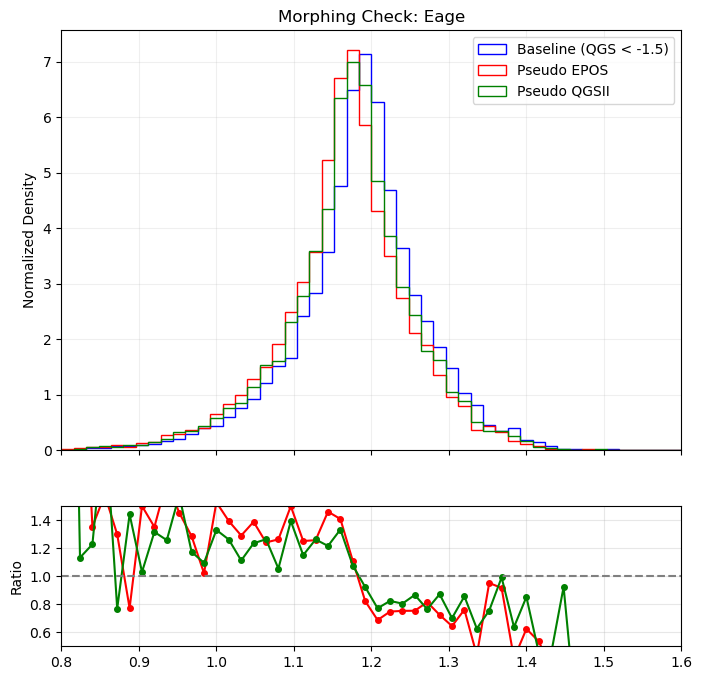

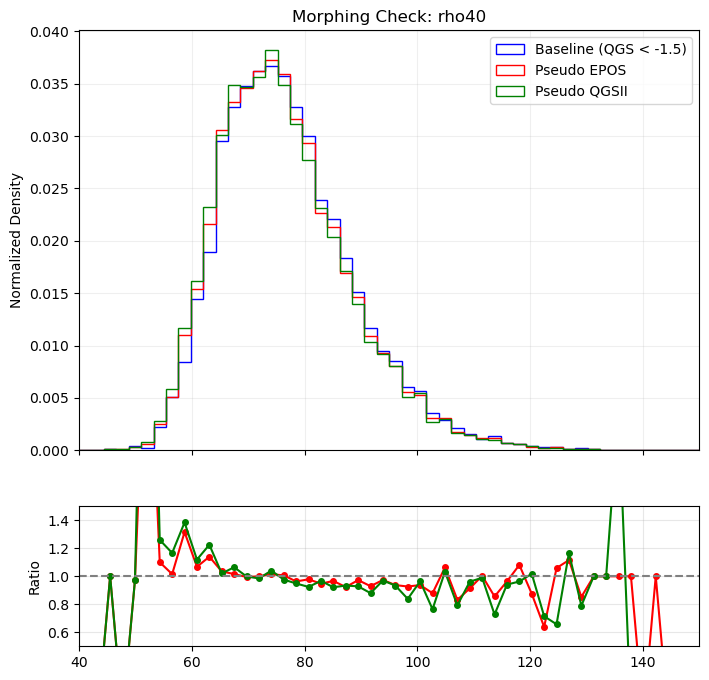

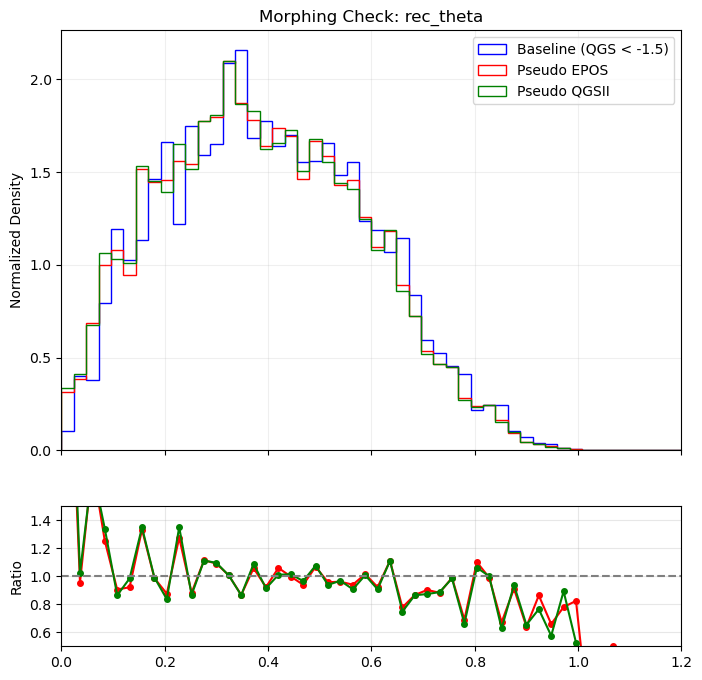

Analysis Ready. You now have:
1. pr_df_large_cut (Central Value)
2. pseudo_ef_large (Systematic Variation 1)
3. pseudo_qf_large (Systematic Variation 2)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

# ==========================================
# 0. 全局配置与工具类
# ==========================================
# 核心结论：仅使用 Rue < -1.5 的数据作为背景模板
TEMPLATE_CUT = -1.5 

class Plotter:
    COLORS = ['blue', 'red', 'green', 'orange', 'purple']
    
    @staticmethod
    def plot_morphing_check(dfs, labels, var, weight_col, bins=50, range_val=None):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), 
                                       gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
        hists = []
        for i, (df, label) in enumerate(zip(dfs, labels)):
            w = df[weight_col] if weight_col in df.columns else np.ones(len(df))
            h, edges, _ = ax1.hist(df[var], bins=bins, range=range_val, weights=w,
                                   histtype='step', lw=2, density=True,
                                   label=label, color=Plotter.COLORS[i % len(Plotter.COLORS)])
            hists.append(h)
            
        ax1.set_ylabel('Normalized Density')
        ax1.legend()
        ax1.set_title(f'Morphing Check: {var}')
        ax1.grid(True, alpha=0.2)

        centers = 0.5 * (edges[:-1] + edges[1:])
        ref_h = hists[0]
        for i in range(1, len(hists)):
            ratio = np.divide(hists[i], ref_h, out=np.zeros_like(hists[i]), where=ref_h!=0)
            ax2.plot(centers, ratio, 'o-', markersize=4, 
                     color=Plotter.COLORS[i % len(Plotter.COLORS)], label=f'Ratio {i}')
        ax2.axhline(1, color='gray', ls='--')
        ax2.set_ylabel('Ratio')
        if range_val: ax2.set_xlim(range_val)
        ax2.set_ylim(0.5, 1.5)
        ax2.grid(True, alpha=0.3)
        plt.show()

class PhysicsMorpher:
    def __init__(self, baseline_small, target_small, weight_col='gaisser_weight'):
        self.base = baseline_small
        self.target = target_small
        self.w_col = weight_col
        self.strategies = {} 

    def learn_diff(self, var, mode='shift'):
        # 清洗数据
        b_vals = pd.to_numeric(self.base[var], errors='coerce').dropna()
        t_vals = pd.to_numeric(self.target[var], errors='coerce').dropna()
        w_b = self.base.loc[b_vals.index, self.w_col]
        w_t = self.target.loc[t_vals.index, self.w_col]

        mean_base = np.average(b_vals, weights=w_b)
        mean_target = np.average(t_vals, weights=w_t)
        
        if mode == 'shift':
            val = mean_target - mean_base
            print(f"   [{var}] SHIFT: {val:+.4f} ({mean_base:.3f} -> {mean_target:.3f})")
        elif mode == 'scale':
            val = mean_target / mean_base
            print(f"   [{var}] SCALE: {val:.4f} ({mean_base:.3f} -> {mean_target:.3f})")
        self.strategies[var] = (mode, val)

    def generate_pseudo(self, df_large):
        df_new = df_large.copy()
        for var, (mode, val) in self.strategies.items():
            df_new[var] = pd.to_numeric(df_new[var], errors='coerce')
            if mode == 'shift':
                df_new[var] = df_new[var] + val
            elif mode == 'scale':
                df_new[var] = df_new[var] * val
        df_new['data_type'] = 'Pseudo_MC'
        return df_new

# ==========================================
# 1. 关键步骤：应用 Rue < -1.5 切选
# ==========================================
print(f"\n>>> Step 1: Applying Template Cut (Rue < {TEMPLATE_CUT})...")

# 1.1 切选 大范围基准数据 (这是我们的核心背景模板)
# 只有切完之后，它才是合格的"背景"
pr_df_large_cut = pr_df_large[pr_df_large['R_ue'] < TEMPLATE_CUT].copy()

# 1.2 切选 小范围数据 (用于学习模型差异)
# 我们必须在同样的相空间内学习差异，否则规律可能不适用
pr_df_cut = pr_df[pr_df['R_ue'] < TEMPLATE_CUT].copy()       # QGS Small
pr_ef_df_cut = pr_ef_df[pr_ef_df['R_ue'] < TEMPLATE_CUT].copy() # EPOS Small
pr_qf_df_cut = pr_qf_df[pr_qf_df['R_ue'] < TEMPLATE_CUT].copy() # QGSII Small

print(f"Events after cut:")
print(f"  Large Base (QGS): {len(pr_df_large)} -> {len(pr_df_large_cut)}")
print(f"  Small Base (QGS): {len(pr_df)} -> {len(pr_df_cut)}")
print(f"  Small Target (EPOS): {len(pr_ef_df)} -> {len(pr_ef_df_cut)}")

# ==========================================
# 2. 学习模型差异 (在 Cut 后的数据上)
# ==========================================
print("\n>>> Step 2: Learning Model Systematics...")

morph_vars = {
    'Eage': 'shift',      # 形状参数 -> 平移
    'rec_theta': 'shift', # 角度重建 -> 平移
    'rho40': 'shift'      # 几何参数 -> 缩放 (按您要求改为 rho40)
}

# --- A. 学习 QGS -> EPOS ---
print("Morphing: QGSJET -> EPOS")
morpher_ef = PhysicsMorpher(pr_df_cut, pr_ef_df_cut, weight_col='gaisser_weight')
for var, mode in morph_vars.items():
    if var in pr_df_cut.columns:
        morpher_ef.learn_diff(var, mode=mode)
    else:
        print(f"Warning: {var} not found in dataframe!")

# --- B. 学习 QGS -> QGSJETII ---
print("Morphing: QGSJET -> QGSJETII")
morpher_qf = PhysicsMorpher(pr_df_cut, pr_qf_df_cut, weight_col='gaisser_weight')
for var, mode in morph_vars.items():
    if var in pr_df_cut.columns:
        morpher_qf.learn_diff(var, mode=mode)

# ==========================================
# 3. 生成伪数据 (应用到 Cut 后的大范围基准)
# ==========================================
print("\n>>> Step 3: Generating Pseudo Data...")

# 这里的输入必须是已经切过 Rue < -1.5 的 pr_df_large_cut
# 因为我们只关心这一部分的系统误差
pseudo_ef_large = morpher_ef.generate_pseudo(pr_df_large_cut)
pseudo_qf_large = morpher_qf.generate_pseudo(pr_df_large_cut)

# ==========================================
# 4. 验证结果
# ==========================================
print("\n>>> Step 4: Validating Systematics Range...")

# 验证 Eage
Plotter.plot_morphing_check(
    [pr_df_large_cut, pseudo_ef_large, pseudo_qf_large],
    ['Baseline (QGS < -1.5)', 'Pseudo EPOS', 'Pseudo QGSII'],
    'Eage', 'gaisser_weight', range_val=(0.8, 1.6)
)

# 验证 rho40
if 'rho40' in pr_df_large_cut.columns:
    Plotter.plot_morphing_check(
        [pr_df_large_cut, pseudo_ef_large, pseudo_qf_large],
        ['Baseline (QGS < -1.5)', 'Pseudo EPOS', 'Pseudo QGSII'],
        'rho40', 'gaisser_weight', range_val=(40, 150) # 根据实际范围调整
    )

# 验证 rec_theta
Plotter.plot_morphing_check(
    [pr_df_large_cut, pseudo_ef_large, pseudo_qf_large],
    ['Baseline (QGS < -1.5)', 'Pseudo EPOS', 'Pseudo QGSII'],
    'rec_theta', 'gaisser_weight', range_val=(0, 1.2)
)

print("Analysis Ready. You now have:")
print("1. pr_df_large_cut (Central Value)")
print("2. pseudo_ef_large (Systematic Variation 1)")
print("3. pseudo_qf_large (Systematic Variation 2)")



>>> Step A: Applying Physics Cuts...
[Bkg Train (QGS)] Cuts applied. Events: 8216 -> 4246
[Signal Train] Cuts applied. Events: 58734 -> 53802
[Exp Data] Cuts applied. Events: 16171 -> 9517
[Sys EPOS] Cuts applied. Events: 8216 -> 4246
[Sys QGSII] Cuts applied. Events: 8216 -> 4246

>>> Step B: K-Fold Training & OOF Prediction...
>>> Starting 5-Fold Cross-Validation (xgb)...

--- Fold 1/5 ---
[0]	validation_0-logloss:0.24984	validation_1-logloss:0.25403
[100]	validation_0-logloss:0.14967	validation_1-logloss:0.16231
[200]	validation_0-logloss:0.14691	validation_1-logloss:0.16180
[240]	validation_0-logloss:0.14610	validation_1-logloss:0.16185

--- Fold 2/5 ---
[0]	validation_0-logloss:0.25187	validation_1-logloss:0.24701
[100]	validation_0-logloss:0.15305	validation_1-logloss:0.14962
[200]	validation_0-logloss:0.15051	validation_1-logloss:0.14835
[300]	validation_0-logloss:0.14843	validation_1-logloss:0.14825
[317]	validation_0-logloss:0.14815	validation_1-logloss:0.14827

--- Fold 3/5 

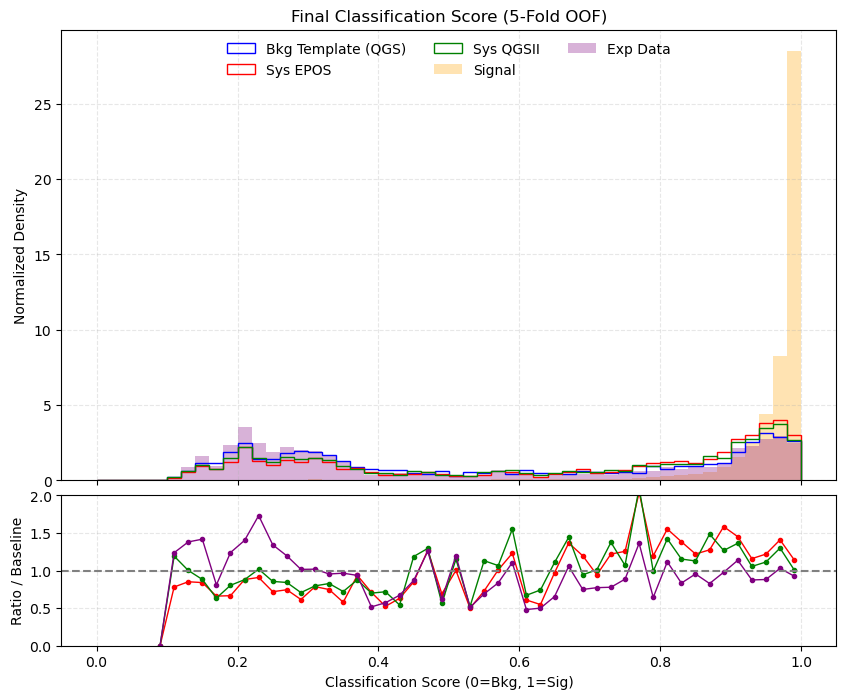

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import copy
# ==========================================
# 0. 全局配置
# ==========================================
# 这里的特征必须与 DataFrame 中的列名完全一致
# 如果你之前叫 'R_mean' 而现在想用 'rho40'，请确保 df 里有 'rho40'
FEATURES = ['rec_theta', 'Eage', 'rho40'] 
TARGET_FLUX = 'gaisser_weight'

# ==========================================
# 1. 类定义 (保持你的架构，稍作优化)
# ==========================================
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

from sklearn.model_selection import train_test_split
# class ClassifierManager:
#     def __init__(self, features, model_type='xgb', device='cpu'):
#         self.features = features
#         self.model_type = model_type.lower()
#         self.device = device
#         self.scaler = StandardScaler()
#         self.model = None
        
#     def prepare_data(self, bkg_df, sig_df, weight_col='gaisser_weight', sig_weight_col='weight', test_size=0.3):
#         """
#         准备数据并自动拆分训练集和验证集
#         test_size: 验证集比例 (默认 30%)
#         """
#         # 1. 提取特征与权重
#         X_bkg = bkg_df[self.features].values
#         X_sig = sig_df[self.features].values
#         w_bkg = bkg_df[weight_col].values
#         w_sig = sig_df[sig_weight_col].values
        
#         # 归一化权重 (防止 Loss 数值过小或梯度爆炸)
#         w_bkg = w_bkg / w_bkg.mean()
#         w_sig = w_sig / w_sig.mean()

#         # 2. 构建全量数据
#         X_raw = np.vstack([X_bkg, X_sig])
#         y_raw = np.concatenate([np.zeros(len(X_bkg)), np.ones(len(X_sig))])
#         w_raw = np.concatenate([w_bkg, w_sig])

#         # 3. 拆分训练集和验证集 (使用 stratify 保证信号比例一致)
#         self.X_train, self.X_val, self.y_train, self.y_val, self.w_train, self.w_val = train_test_split(
#             X_raw, y_raw, w_raw, test_size=test_size, random_state=42, stratify=y_raw
#         )

#         # 4. 仅在训练集上 Fit Scaler
#         self.X_train_scaled = self.scaler.fit_transform(self.X_train)
#         self.X_val_scaled = self.scaler.transform(self.X_val)
        
#         # 5. 模型初始化 (根据类型分流)
#         if self.model_type == 'xgb':
#             self.model = xgb.XGBClassifier(
#                 n_estimators=1000, 
#                 max_depth=4,
#                 learning_rate=0.03, 
#                 objective='binary:logistic',
#                 tree_method='gpu_hist' if 'cuda' in self.device else 'hist',
#                 n_jobs=-1,
#                 random_state=42,
#                 early_stopping_rounds=50 # Early Stopping 放这里
#             )
#         elif self.model_type == 'mlp':
#             # 转换为 Tensor 并移动到 Device
#             self.X_train_tensor = torch.FloatTensor(self.X_train_scaled).to(self.device)
#             self.y_train_tensor = torch.FloatTensor(self.y_train).unsqueeze(1).to(self.device)
#             self.w_train_tensor = torch.FloatTensor(self.w_train).unsqueeze(1).to(self.device)
            
#             self.X_val_tensor = torch.FloatTensor(self.X_val_scaled).to(self.device)
#             self.y_val_tensor = torch.FloatTensor(self.y_val).unsqueeze(1).to(self.device)
#             self.w_val_tensor = torch.FloatTensor(self.w_val).unsqueeze(1).to(self.device)
            
#             # 初始化 MLP 模型
#             self.model = MLP(len(self.features)).to(self.device)
#             self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
#             # reduction='none' 是为了手动乘权重
#             self.criterion = nn.BCELoss(reduction='none') 

#     def train(self, epochs=1000):
#         """执行训练"""
#         # --- 分支 A: XGBoost ---
#         if self.model_type == 'xgb':
#             print(">>> Training XGBoost with Early Stopping...")
#             eval_set = [(self.X_train_scaled, self.y_train), (self.X_val_scaled, self.y_val)]
            
#             self.model.fit(
#                 self.X_train_scaled, 
#                 self.y_train, 
#                 sample_weight=self.w_train,
#                 eval_set=eval_set,
#                 sample_weight_eval_set=[self.w_train, self.w_val],
#                 verbose=50
#             )
#             try:
#                 print(f"XGBoost Training Complete. Best Iteration: {self.model.best_iteration}")
#             except AttributeError:
#                 print("XGBoost Training Complete.")

#         # --- 分支 B: MLP (PyTorch) ---
#         elif self.model_type == 'mlp':
#             print(f">>> Training MLP on {self.device}...")
#             self.model.train()
            
#             for epoch in range(epochs):
#                 self.optimizer.zero_grad()
                
#                 # Forward
#                 outputs = self.model(self.X_train_tensor)
                
#                 # Weighted Loss 计算: mean( BCELoss * weight )
#                 loss = (self.criterion(outputs, self.y_train_tensor) * self.w_train_tensor).mean()
                
#                 # Backward
#                 loss.backward()
#                 self.optimizer.step()
                
#                 # 打印日志 (每 20 轮看一次验证集 Loss)
#                 if (epoch + 1) % 100 == 0:
#                     self.model.eval()
#                     with torch.no_grad():
#                         val_out = self.model(self.X_val_tensor)
#                         val_loss = (self.criterion(val_out, self.y_val_tensor) * self.w_val_tensor).mean()
#                     self.model.train() # 切回训练模式
#                     print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

#     def predict(self, df):
#         """预测并返回概率分数 (0 到 1 之间)"""
#         # 1. 提取特征并清洗
#         df_clean = df[self.features].copy()
#         for col in self.features:
#             df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
#         df_clean = df_clean.fillna(0).infer_objects(copy=False)
        
#         X = df_clean.values
#         X_scaled = self.scaler.transform(X) # 使用训练集的 scaler
        
#         # --- 分支 A: XGBoost 预测 ---
#         if self.model_type == 'xgb':
#             try:
#                 if hasattr(self.model, 'best_iteration') and self.model.best_iteration is not None:
#                     limit = self.model.best_iteration + 1
#                     scores = self.model.predict_proba(X_scaled, iteration_range=(0, limit))[:, 1]
#                 else:
#                     scores = self.model.predict_proba(X_scaled)[:, 1]
#             except (AttributeError, TypeError):
#                 scores = self.model.predict_proba(X_scaled)[:, 1]
        
#         # --- 分支 B: MLP 预测 ---
#         elif self.model_type == 'mlp':
#             self.model.eval()
#             X_tensor = torch.FloatTensor(X_scaled).to(self.device)
#             with torch.no_grad():
#                 # MLP 输出是 [N, 1] 的 Tensor，需要 flatten 到 [N] 并转 numpy
#                 scores = self.model(X_tensor).cpu().numpy().flatten()
            
#         return scores
    
#     def get_feature_importance(self):
#         """查看特征重要性 (仅 XGB 有效)"""
#         if self.model_type == 'xgb':
#             return dict(zip(self.features, self.model.feature_importances_))
#         return {}


class ClassifierManager:
    def __init__(self, features, model_type='xgb', device='cpu'):
        self.features = features
        self.model_type = model_type.lower()
        self.device = device
        
        # 存储 K 折的所有模型和对应的 Scaler
        self.trained_models = []
        self.trained_scalers = []
        
    def prepare_data(self, bkg_df, sig_df, weight_col='gaisser_weight', sig_weight_col='weight'):
        """
        准备数据：只合并，不拆分 Train/Test。
        Train/Test 拆分将在 train_kfold 内部动态进行。
        """
        # 1. 提取特征
        X_bkg = bkg_df[self.features].values
        X_sig = sig_df[self.features].values
        
        # 2. 提取权重 & 归一化
        w_bkg = bkg_df[weight_col].values
        w_sig = sig_df[sig_weight_col].values
        w_bkg = w_bkg / w_bkg.mean()
        w_sig = w_sig / w_sig.mean()

        # 3. 合并全量数据
        self.X_raw = np.vstack([X_bkg, X_sig])
        self.y_raw = np.concatenate([np.zeros(len(X_bkg)), np.ones(len(X_sig))])
        self.w_raw = np.concatenate([w_bkg, w_sig])
        
        # 记录边界，方便后续把 OOF 分数拆回 Bkg 和 Sig
        self.n_bkg = len(X_bkg)

    def _get_new_model(self):
        """内部函数：获取一个新的、未训练的模型实例"""
        if self.model_type == 'xgb':
            return xgb.XGBClassifier(
                n_estimators=1000,
                max_depth=4,
                learning_rate=0.03,
                objective='binary:logistic',
                tree_method='gpu_hist' if 'cuda' in self.device else 'hist',
                n_jobs=-1,
                random_state=42,
                early_stopping_rounds=50
            )
        elif self.model_type == 'mlp':
            return MLP(len(self.features)).to(self.device)

    def train_kfold(self, n_splits=5, epochs=800):
        """
        执行 K-Fold 交叉验证训练
        返回: oof_scores (全量训练数据的预测分)
        """
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        # 用于存储全量数据的 OOF 预测结果
        oof_preds = np.zeros(len(self.y_raw))
        
        self.trained_models = []
        self.trained_scalers = []

        print(f">>> Starting {n_splits}-Fold Cross-Validation ({self.model_type})...")

        for fold, (train_idx, val_idx) in enumerate(skf.split(self.X_raw, self.y_raw)):
            print(f"\n--- Fold {fold+1}/{n_splits} ---")
            
            # 1. 切分数据
            X_train, y_train, w_train = self.X_raw[train_idx], self.y_raw[train_idx], self.w_raw[train_idx]
            X_val, y_val, w_val = self.X_raw[val_idx], self.y_raw[val_idx], self.w_raw[val_idx]
            
            # 2. 独立 Scaling (防止信息泄露：只在 Train 上 fit)
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            self.trained_scalers.append(scaler)
            
            # 3. 初始化新模型
            model = self._get_new_model()
            
            # 4. 训练
            if self.model_type == 'xgb':
                model.fit(
                    X_train_scaled, y_train, sample_weight=w_train,
                    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
                    sample_weight_eval_set=[w_train, w_val],
                    verbose=100
                )
                # 预测验证集 (OOF)
                try:
                    limit = model.best_iteration + 1
                    preds = model.predict_proba(X_val_scaled, iteration_range=(0, limit))[:, 1]
                except AttributeError:
                    preds = model.predict_proba(X_val_scaled)[:, 1]

            elif self.model_type == 'mlp':
                # 转换为 Tensor
                Xt = torch.FloatTensor(X_train_scaled).to(self.device)
                yt = torch.FloatTensor(y_train).unsqueeze(1).to(self.device)
                wt = torch.FloatTensor(w_train).unsqueeze(1).to(self.device)
                Xv = torch.FloatTensor(X_val_scaled).to(self.device)
                
                optimizer = optim.Adam(model.parameters(), lr=0.001)
                criterion = nn.BCELoss(reduction='none')
                
                model.train()
                for epoch in range(epochs):
                    optimizer.zero_grad()
                    out = model(Xt)
                    loss = (criterion(out, yt) * wt).mean()
                    loss.backward()
                    optimizer.step()
                
                # 预测验证集
                model.eval()
                with torch.no_grad():
                    preds = model(Xv).cpu().numpy().flatten()
            
            # 5. 存储结果
            oof_preds[val_idx] = preds # 将验证集的预测填回对应的位置
            self.trained_models.append(model)
            
        print("\n>>> K-Fold Training Complete.")
        return oof_preds

    def predict_ensemble(self, df):
        """
        对外部数据进行预测。
        机制：使用所有 K 个模型分别预测，然后取平均值。
        这能极大降低预测的方差。
        """
        # 1. 数据清洗
        df_clean = df[self.features].copy()
        for col in self.features:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        df_clean = df_clean.fillna(0).infer_objects(copy=False)
        X_raw = df_clean.values
        
        all_fold_preds = []
        
        # 2. 遍历所有 Fold 的模型进行预测
        for i, (model, scaler) in enumerate(zip(self.trained_models, self.trained_scalers)):
            # 必须使用该 Fold 对应的 Scaler
            X_scaled = scaler.transform(X_raw)
            
            if self.model_type == 'xgb':
                try:
                    # 使用最佳迭代次数
                    if hasattr(model, 'best_iteration') and model.best_iteration is not None:
                        limit = model.best_iteration + 1
                        p = model.predict_proba(X_scaled, iteration_range=(0, limit))[:, 1]
                    else:
                        p = model.predict_proba(X_scaled)[:, 1]
                except:
                    p = model.predict_proba(X_scaled)[:, 1]
            elif self.model_type == 'mlp':
                model.eval()
                Xt = torch.FloatTensor(X_scaled).to(self.device)
                with torch.no_grad():
                    p = model(Xt).cpu().numpy().flatten()
            
            all_fold_preds.append(p)
            
        # 3. 取平均 (Ensemble Averaging)
        avg_preds = np.mean(all_fold_preds, axis=0)
        return avg_preds
    
    def get_feature_importance(self):
        """返回第一折模型的特征重要性 (仅供参考)"""
        if self.model_type == 'xgb' and self.trained_models:
            return dict(zip(self.features, self.trained_models[0].feature_importances_))
        return {}
class Plotter:
    COLORS = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'cyan']
    
    @staticmethod
    def plot_score(dfs, labels, weights, bins=50, title="Score Distribution"):
        # 1. 设置画板：上大下小 (3:1)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), 
                                       gridspec_kw={'height_ratios': [3, 1]}, 
                                       sharex=True)
        
        hists = []
        edges = None
        
        # ==========================================
        # 上图：分布直方图 (Main Distribution)
        # ==========================================
        for i, (df, label, w) in enumerate(zip(dfs, labels, weights)):
            # 视觉样式：最后两个(Signal/Exp)用填充，其他的用线条
            is_ref = (i >= len(dfs) - 2) 
            h_type = 'stepfilled' if is_ref else 'step'
            alpha = 0.3 if is_ref else 1.0
            lw = 2 if not is_ref else 1.5
            color = Plotter.COLORS[i % len(Plotter.COLORS)]
            
            # 绘制并保存直方图数据
            # density=True 用于对比形状
            h, bin_edges, _ = ax1.hist(df['mlp_score'], bins=bins, range=(0, 1), weights=w,
                                       histtype=h_type, alpha=alpha, lw=lw, density=True, 
                                       label=label, color=color)
            hists.append(h)
            if edges is None: edges = bin_edges
            
        ax1.set_ylabel('Normalized Density')
        # ax1.set_yscale('log') # 强烈建议 Score 开启 Log 模式，否则看不到高分段细节
        ax1.set_title(title)
        # 图例放上面，避免遮挡数据
        ax1.legend(loc='upper center',  ncol=3, frameon=False)
        ax1.grid(True, which='both', linestyle='--', alpha=0.3)

        # ==========================================
        # 下图：比例图 (Ratio Plot)
        # ==========================================
        # 默认以第一个数据集 (dfs[0], 即 Baseline) 作为分母
        ref_h = hists[0]
        centers = 0.5 * (edges[:-1] + edges[1:])
        
        for i in range(1, len(hists)):
            # 计算 Ratio，处理除零情况
            # 信号 (Signal) 分布通常和背景差异极大，画 Ratio 可能会让图变得很乱
            # 你可以选择跳过 Signal (通常 label 包含 'Signal' 或 'MN')
            if 'Signal' in labels[i] or 'MN' in labels[i]:
                continue

            ratio = np.divide(hists[i], ref_h, out=np.zeros_like(ref_h), where=ref_h!=0)
            
            # 只画有数据的点，避免由 0/0 产生的噪点
            mask = ref_h > 0
            ax2.plot(centers[mask], ratio[mask], 'o-', markersize=3, lw=1,
                     color=Plotter.COLORS[i % len(Plotter.COLORS)])
        
        # 参考线
        ax2.axhline(1, color='gray', linestyle='--')
        
        ax2.set_xlabel('Classification Score (0=Bkg, 1=Sig)')
        ax2.set_ylabel('Ratio / Baseline')
        
        # 设置 Ratio 的显示范围，避免个别极端值破坏视图
        ax2.set_ylim(0.0, 2.0) 
        ax2.grid(True, which='both', linestyle='--', alpha=0.3)
        
        # 调整间距
        plt.subplots_adjust(hspace=0.05)
        plt.show()

# ==========================================
# 2. 数据准备与 Cut 策略
# ==========================================
print("\n>>> Step A: Applying Physics Cuts...")

# 定义 Cut 函数 (只切物理窗口，不切区分变量)
def apply_analysis_cuts(df, dataset_name):

    cond_E = (df['recE'] > 1.9) & (df['recE'] < 2.1)
    
    cond_R = (df['rho40'] > 0) 

    # 组合 Cut
    mask = cond_E & cond_R
    df_cut = df[mask].copy()
    
    print(f"[{dataset_name}] Cuts applied. Events: {len(df)} -> {len(df_cut)}")
    return df_cut

# --- 应用 Cuts ---
# 1. 训练用背景 (使用 Shape Invariant Template: Rue < -1.5)
# 注意：pr_df_large_cut 已经是 Rue < -1.5 了，这里再加 recE cut
bkg_train_final = apply_analysis_cuts(pr_df_large_cut, "Bkg Train (QGS)")

# 2. 训练用信号 (必须是 Rue < -2.6)
sig_train_final = mn_df_large[mn_df_large['R_ue'] < -2.6].copy()
sig_train_final = apply_analysis_cuts(sig_train_final, "Signal Train")

# 3. 实验数据 (必须是 Rue < -2.6)
exp_final = exp_muon_Rue_df_large[exp_muon_Rue_df_large['R_ue'] < -2.6].copy()
exp_final = apply_analysis_cuts(exp_final, "Exp Data")

# 4. 系统误差样本 (Pseudo EPOS/QGSII)
pseudo_ef_final = apply_analysis_cuts(pseudo_ef_large, "Sys EPOS")
pseudo_qf_final = apply_analysis_cuts(pseudo_qf_large, "Sys QGSII")

# ==========================================
# 3. K-Fold 训练
# ==========================================
print("\n>>> Step B: K-Fold Training & OOF Prediction...")

# 初始化 (推荐用 XGB, CPU/GPU 自动适配)
# 注意：如果要用 MLP，只需改 model_type='mlp'
manager = ClassifierManager(FEATURES, model_type='xgb', device='cpu')

# 准备数据 (只传入，不切分)
manager.prepare_data(bkg_train_final, sig_train_final, weight_col=TARGET_FLUX, sig_weight_col='weight')

# 执行 5-Fold 训练
# 返回的 oof_scores 是全量训练数据的预测值
# 关键：这个分数是"干净"的，没有过拟合
oof_scores_total = manager.train_kfold(n_splits=5)

# 将 OOF 分数拆分回 Bkg 和 Sig DataFrame
# 顺序必须和 prepare_data 中的合并顺序一致 (先 Bkg 后 Sig)
n_bkg = manager.n_bkg
bkg_train_final['mlp_score'] = oof_scores_total[:n_bkg]
sig_train_final['mlp_score'] = oof_scores_total[n_bkg:]

print("OOF Scores assigned back to training dataframes.")

# ==========================================
# 4. 外部数据集成预测 (Ensemble Prediction)
# ==========================================
print("\n>>> Step C: Ensemble Inference on External Data...")

# 对于实验数据和系统误差样本，使用 5 个模型的平均值
# 这比单模型预测更稳健
exp_final['mlp_score'] = manager.predict_ensemble(exp_final)
pseudo_ef_final['mlp_score'] = manager.predict_ensemble(pseudo_ef_final)
pseudo_qf_final['mlp_score'] = manager.predict_ensemble(pseudo_qf_final)

# ==========================================
# 5. 结果可视化与检查
# ==========================================
print("\n>>> Step D: Visualizing Results...")

# 输出高分区的统计信息
CUT_SCORE = 0.
n_exp = exp_final[exp_final['mlp_score'] > CUT_SCORE]['weight'].sum()
n_bkg = bkg_train_final[bkg_train_final['mlp_score'] > CUT_SCORE][TARGET_FLUX].sum()
n_sig = sig_train_final[sig_train_final['mlp_score'] > CUT_SCORE]['weight'].sum()

print(f"\n[Check] Events with Score > {CUT_SCORE} (Annualized):")
print(f"  Exp Data: {n_exp*365*86400:.2f}")
# print(f"  MC Bkg :  {n_bkg*365*86400:.2f}")
print(f"  Signal :  {n_sig*365*86400:.2f}")

# 绘图
dfs_to_plot = [bkg_train_final, pseudo_ef_final, pseudo_qf_final, sig_train_final, exp_final]
labels = ['Bkg Template (QGS)', 'Sys EPOS', 'Sys QGSII', 'Signal', 'Exp Data']
weights = [
    bkg_train_final[TARGET_FLUX], 
    pseudo_ef_final[TARGET_FLUX], 
    pseudo_qf_final[TARGET_FLUX], 
    sig_train_final['weight'], 
    exp_final['weight']
]

Plotter.plot_score(dfs_to_plot, labels, weights, title="Final Classification Score (5-Fold OOF)")



下面是考虑recE,Rue参数的误差,这两个是关键参数,需要考虑

这两个参数的误差波动范围有脚本/home/zhonghua/Filt_Event/UpperLimit/uncertainty/exp_npz_check.ipynb,中给出

UNC_E = 0.02    
UNC_RUE = 0.05

这两个值是保守且合理的.


>>> Step E: Calculating Cut Systematics (recE & Rue)...
Generating Variations (Template Validity Cut < -1.5 applied to Bkg)...

[Systematics Check] Total Yields:
Bkg Nominal:   0.26
Bkg recE Up:   0.24
Bkg recE Down: 0.29
Bkg Rue Tight: 0.26
Bkg Rue Loose: 0.26


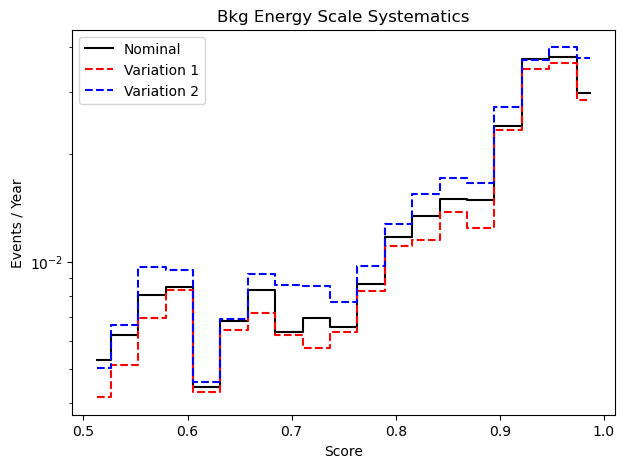

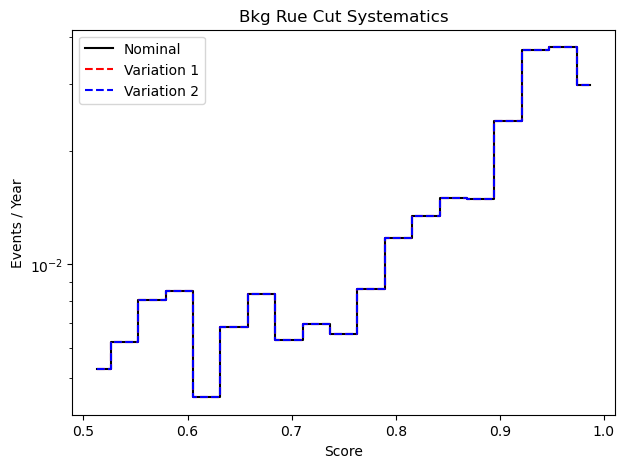

In [27]:
# ==========================================
# 6. Calculating Cut Systematics (Corrected Logic)
# ==========================================
print("\n>>> Step E: Calculating Cut Systematics (recE & Rue)...")

# -------------------------------------------------
# 0. Preparation: Score Full Datasets if needed
# -------------------------------------------------
if 'mlp_score' not in pr_df_large.columns:
    print("Scoring full background dataset...")
    pr_df_large['mlp_score'] = manager.predict_ensemble(pr_df_large)

if 'mlp_score' not in mn_df_large.columns:
    print("Scoring full signal dataset...")
    mn_df_large['mlp_score'] = manager.predict_ensemble(mn_df_large)

# -------------------------------------------------
# 1. Define Function with "Validity Cut"
# -------------------------------------------------
# Constants
BINS = np.linspace(0.5, 1, 20) 
CUT_E_NOM = 1.9
CUT_E_MAX = 2.1
CUT_RUE_NOM = -2.6
CUT_RHO_MIN = 0 

# *** KEY FIX: The Template Validity Cut ***
# This ensures we only use MC events that we proved to match Data shape
TEMPLATE_VALIDITY_CUT = -1.5 

def get_counts_varied(df, score_col, weight_col, 
                      e_min, e_max, rue_max, 
                      is_mc_background=False):
    """
    Args:
        is_mc_background: If True, enforces Rue < -1.5 validity cut
    """
    # 1. Start with the Analysis Cuts (Dynamic)
    cond = (df['recE'] > e_min) & (df['recE'] < e_max) & \
           (df['rho40'] > CUT_RHO_MIN)
    
    # 2. *** APPLY VALIDITY CUT ***
    # If this is Proton MC, we must AND it with Rue < -1.5
    # (Although mathematically -2.6 implies < -1.5, this makes logic explicit 
    # and safe if you ever test looser cuts)
    if is_mc_background:
        cond = cond & (df['R_ue'] < TEMPLATE_VALIDITY_CUT)
    else:
        cond= cond & (df['R_ue'] < rue_max)

    df_cut = df[cond]
    
    # 3. Get Scores and Weights
    scores = df_cut[score_col].values
    weights = df_cut[weight_col].values
    
    # 4. Histogram & Normalize
    counts, _ = np.histogram(scores, bins=BINS, weights=weights)
    counts = counts 
    
    return np.maximum(counts, 1e-6)

# -------------------------------------------------
# 2. Generate Variations
# -------------------------------------------------
UNC_E = 0.02    
UNC_RUE = 0.05

print(f"Generating Variations (Template Validity Cut < {TEMPLATE_VALIDITY_CUT} applied to Bkg)...")

# --- A. Background (Proton) ---
# Note: set is_mc_background=True
bkg_nom_hist = get_counts_varied(pr_df_large, 'mlp_score', TARGET_FLUX, 
                                 CUT_E_NOM, CUT_E_MAX, CUT_RUE_NOM, 
                                 is_mc_background=True)

# recE Variations
bkg_recE_up = get_counts_varied(pr_df_large, 'mlp_score', TARGET_FLUX,
                                CUT_E_NOM * (1 + UNC_E), CUT_E_MAX * (1 + UNC_E), CUT_RUE_NOM,
                                is_mc_background=True)

bkg_recE_down = get_counts_varied(pr_df_large, 'mlp_score', TARGET_FLUX,
                                  CUT_E_NOM * (1 - UNC_E), CUT_E_MAX * (1 - UNC_E), CUT_RUE_NOM,
                                  is_mc_background=True)

# Rue Variations
# Important Check: Even for "Loose" (-2.55), it is still < -1.5, so validity holds.
bkg_rue_tight = get_counts_varied(pr_df_large, 'mlp_score', TARGET_FLUX,
                                  CUT_E_NOM, CUT_E_MAX, CUT_RUE_NOM - UNC_RUE,
                                  is_mc_background=True)

bkg_rue_loose = get_counts_varied(pr_df_large, 'mlp_score', TARGET_FLUX,
                                  CUT_E_NOM, CUT_E_MAX, CUT_RUE_NOM + UNC_RUE,
                                  is_mc_background=True)

# --- B. Signal (Monopole) ---
# Signal does not need validity cut (it's not background)
sig_nom_hist = get_counts_varied(mn_df_large, 'mlp_score', 'weight',
                                 CUT_E_NOM, CUT_E_MAX, CUT_RUE_NOM)

sig_recE_up = get_counts_varied(mn_df_large, 'mlp_score', 'weight',
                                CUT_E_NOM * (1 + UNC_E), CUT_E_MAX * (1 + UNC_E), CUT_RUE_NOM)

sig_recE_down = get_counts_varied(mn_df_large, 'mlp_score', 'weight',
                                  CUT_E_NOM * (1 - UNC_E), CUT_E_MAX * (1 - UNC_E), CUT_RUE_NOM)

# -------------------------------------------------
# 3. Validation
# -------------------------------------------------
print(f"\n[Systematics Check] Total Yields:")
print(f"Bkg Nominal:   {bkg_nom_hist.sum():.2f}")
# Bkg Nominal should be exactly the same as the one used in the limit calculation
# if BINS and Cuts are identical.

print(f"Bkg recE Up:   {bkg_recE_up.sum():.2f}")
print(f"Bkg recE Down: {bkg_recE_down.sum():.2f}")
print(f"Bkg Rue Tight: {bkg_rue_tight.sum():.2f}")
print(f"Bkg Rue Loose: {bkg_rue_loose.sum():.2f}")

def plot_sys_check(nom, up, down, title):
    plt.figure(figsize=(7, 5))
    x = (BINS[:-1] + BINS[1:]) / 2
    plt.step(x, nom, where='mid', label='Nominal', color='black')
    plt.step(x, up, where='mid', label='Variation 1', linestyle='--', color='red')
    plt.step(x, down, where='mid', label='Variation 2', linestyle='--', color='blue')
    plt.yscale('log')
    plt.title(title)
    plt.legend()
    plt.xlabel("Score")
    plt.ylabel("Events / Year")
    plt.show()

plot_sys_check(bkg_nom_hist, bkg_recE_up, bkg_recE_down, "Bkg Energy Scale Systematics")
plot_sys_check(bkg_nom_hist, bkg_rue_tight, bkg_rue_loose, "Bkg Rue Cut Systematics")


下面是考虑了不同强相互作用带来的score shape上的误差

并且将上面得到的recE 参数的误差综合起来,生成了pyhf使用的JSON文件,用于后续的limit计算

值得注意的是:spec里面以后一个整体拟合参数mu_bkg, 这个作用是可以整体浮动bkg的数量,以匹配到observed counts

>>> Extracting histograms for Limit Calculation...
>>> Integrating recE Systematics...


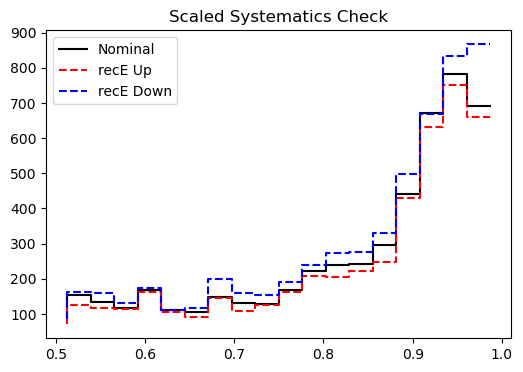

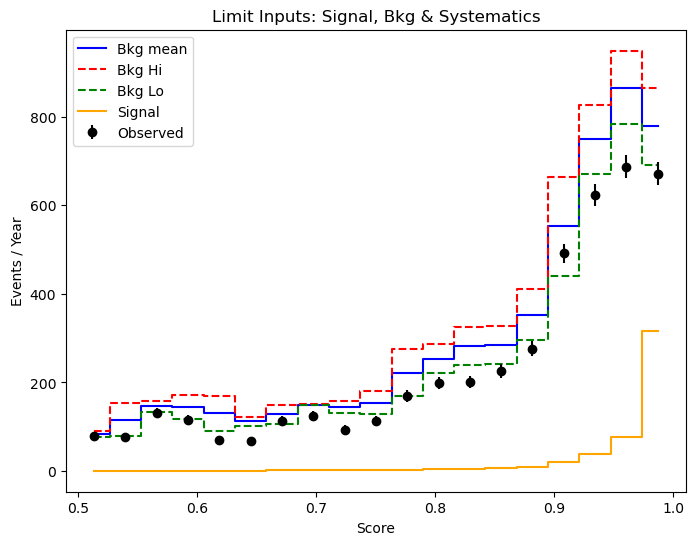

[OK] JSON saved to /home/zhonghua/Filt_Event/UpperLimit/uncertainty/Transformer_baseline/model_with_free_bkg_ABCD.json


In [30]:
import numpy as np
import json
import matplotlib.pyplot as plt


# =====================================================
# 1. Configuration & Data Extraction
# =====================================================

# Define score bins (e.g., 10 bins from 0 to 1)
# You might want to optimize this. For limits, often the last few high-score bins matter most.
BINS = np.linspace(0.5, 1, 20)

def get_counts(df, score_col, weight_col, bins, scaled_num=100):
    """
    Helper to extract weighted histogram counts.
    Ensures no bin has 0 content (replaces with small epsilon) for fit stability.
    """
    scores = df[score_col].values
    weights = df[weight_col].values
    
    ratio_left = 1 - df[df[score_col] < bins[0]][weight_col].sum()/df[weight_col].sum()
    counts, gaps = np.histogram(scores, bins=bins, weights=weights, density=True)
    
    # Scale to annual yield if weights are rates (events/sec)
    # Assuming input weights are rates, multiply by seconds in a year
    # IF your weights are already event counts, remove this factor.
    # Based on previous context, weights seemed to be rates.
    SECONDS_PER_YEAR = 1 
    counts = counts * SECONDS_PER_YEAR * scaled_num * (bins[1] - bins[0]) * ratio_left
    
    # Avoid zero bins for statistical stability
    counts = np.maximum(counts, 1e-6)
    return counts

print(">>> Extracting histograms for Limit Calculation...")



num_dict={
    'bkg_nom': 9622,
    'bkg_ef': 9622,
    'bkg_qf': 9622,
    'sig_nom': 494,
    'obs_counts': 9622
}

# 1. Nominal Background (QGSJET)
bkg_nom = get_counts(bkg_train_final, 'mlp_score', TARGET_FLUX, BINS, scaled_num=num_dict['bkg_nom'])

# 2. Systematic Variations (EPOS & QGSII)
bkg_ef = get_counts(pseudo_ef_final, 'mlp_score', TARGET_FLUX, BINS, scaled_num=num_dict['bkg_ef'])
bkg_qf = get_counts(pseudo_qf_final, 'mlp_score', TARGET_FLUX, BINS, scaled_num=num_dict['bkg_qf'])

# 3. Signal
sig_nom = get_counts(sig_train_final, 'mlp_score', 'weight', BINS, scaled_num=num_dict['sig_nom'])

# 4. Observation (Experiment)
obs_counts = get_counts(exp_final, 'mlp_score', 'weight', BINS, scaled_num=num_dict['obs_counts'])



# ... (接在 bkg_nom, obs_counts 等计算代码之后) ...

# =====================================================
# [新增] 1.5 处理 recE 系统误差的归一化
# =====================================================
print(">>> Integrating recE Systematics...")

# 假设你从 Step E 拿到了以下原始直方图 (Raw Arrays)
# 如果变量名不一样，请替换成你实际的变量名
# 注意：这些数组的 bin 必须和当前的 BINS 完全一致！
# raw_bkg_nom_hist 是 Step E 里的 bkg_nom_hist
# bkg_recE_up, bkg_recE_down 是 Step E 的结果

# 1. 计算当前代码的缩放因子 (Scale Factor)
# 当前脚本里的 bkg_nom 已经被强制缩放到了 num_dict['bkg_nom'] (9622)
# 我们需要知道这个缩放倍数是多少，以便把同样的倍数乘给 Up/Down
# 注意：这里需要 Step E 里的原始 nominal 数组来算比例
# 如果 Step E 的数据没传过来，可以用 bkg_train_final 现算一个 raw sum
raw_bkg_sum = bkg_train_final[TARGET_FLUX].sum() # 近似原始总权重
current_bkg_sum = np.sum(bkg_nom)
scale_factor_bkg = current_bkg_sum / raw_bkg_sum

# 或者是更直接的方法：如果你有 Step E 的 bkg_nom_hist
# scale_factor_bkg = np.sum(bkg_nom) / np.sum(bkg_nom_hist_from_step_E)

# 为了演示，我们假设 scaling 逻辑是线性的，直接用 ratios
# 正确的做法：保持 Shape 变化，同时保留 Yield 变化
# Up_scaled = Up_raw * (Current_Nominal_Sum / Raw_Nominal_Sum)

# 这里我们需要一点技巧：
# 因为你的 get_counts 函数里有复杂的 scaled_num * (bins[1]-bins[0]) * ratio_left 逻辑
# 最稳妥的办法是：复用 get_counts 函数逻辑，或者手动应用比例。

# 【推荐方案】如果 Step E 的数组是 numpy array：
# 直接按“总数比例”缩放
# 假设 raw_bkg_recE_up 是 Step E 算出来的原始数组
# 我们先算出它相对于 raw_nominal 变化了多少 (Ratio)
# 然后把这个 Ratio 应用到当前的 bkg_nom 上

# 1. 计算原始变化比例 (Shape + Rate)
# 避免除以 0，加个 eps
ratio_up_bkg = bkg_recE_up / (bkg_nom_hist + 1e-9) 
ratio_down_bkg = bkg_recE_down / (bkg_nom_hist + 1e-9)

# 2. 应用到当前缩放后的 bkg_nom
# 这样既保留了当前的 9622 总数基准，又保留了 recE 带来的相对变化
bkg_recE_up_scaled = bkg_nom * ratio_up_bkg
bkg_recE_down_scaled = bkg_nom * ratio_down_bkg

# 3. 对信号做同样处理 (如果有信号误差)
ratio_up_sig = sig_recE_up / (sig_nom_hist + 1e-9)
ratio_down_sig = sig_recE_down / (sig_nom_hist + 1e-9)

sig_recE_up_scaled = sig_nom * ratio_up_sig
sig_recE_down_scaled = sig_nom * ratio_down_sig

# 检查一下数值是否正常 (没有 NaN 或 Inf)
bkg_recE_up_scaled = np.nan_to_num(bkg_recE_up_scaled, nan=1e-6)
bkg_recE_down_scaled = np.nan_to_num(bkg_recE_down_scaled, nan=1e-6)
sig_recE_up_scaled = np.nan_to_num(sig_recE_up_scaled, nan=1e-6)
sig_recE_down_scaled = np.nan_to_num(sig_recE_down_scaled, nan=1e-6)

# 可视化检查一下 (可选)
centers = (BINS[:-1] + BINS[1:]) / 2
plt.figure(figsize=(6,4))
plt.step(centers, bkg_nom, label='Nominal', color='k')
plt.step(centers, bkg_recE_up_scaled, label='recE Up', linestyle='--', color='r')
plt.step(centers, bkg_recE_down_scaled, label='recE Down', linestyle='--', color='b')
plt.title("Scaled Systematics Check")
plt.legend()
plt.show()

# =====================================================
# 2. Construct Envelope for Systematics
# =====================================================
# We take the envelope of all background models as the shape uncertainty
raw_hi = np.max([bkg_nom, bkg_ef, bkg_qf], axis=0)
raw_lo = np.min([bkg_nom, bkg_ef, bkg_qf], axis=0)

# Ensure numeric stability (grad_eps) so hi > lo
grad_eps = bkg_nom * 1e-5 + 1e-5
bkg_hi = np.maximum(raw_hi, bkg_nom + grad_eps)
bkg_lo = np.minimum(raw_lo, bkg_nom - grad_eps)
bkg_mean = (bkg_hi + bkg_lo) / 2

# Optional: Visualize the inputs to the limit
plt.figure(figsize=(8,6))
centers = (BINS[:-1] + BINS[1:]) / 2
plt.step(centers, bkg_mean, where='mid', label='Bkg mean', color='blue')
plt.step(centers, bkg_hi, where='mid', label='Bkg Hi', linestyle='--', color='red')
plt.step(centers, bkg_lo, where='mid', label='Bkg Lo', linestyle='--', color='green')
plt.step(centers, sig_nom, where='mid', label='Signal', color='orange')
plt.errorbar(centers, obs_counts, yerr=np.sqrt(obs_counts), fmt='o', color='black', label='Observed')
# plt.yscale('log')
plt.legend()
plt.title("Limit Inputs: Signal, Bkg & Systematics")
plt.xlabel("Score")
plt.ylabel("Events / Year")
plt.show()

# =====================================================
# 3. Build PyHF JSON Specification
# =====================================================
# spec = {
#     "channels": [
#         {
#             "name": "single_channel",
#             "samples": [
#                 {
#                     "name": "background",
#                     # "data": bkg_nom.tolist(),
#                     "data": bkg_mean.tolist(),
#                     "modifiers": [
#                         # 1. Model Shape Uncertainty (Histosys)
#                         {
#                             "name": "model_shape_sys",
#                             "type": "histosys",
#                             "data": {
#                                 "lo_data": bkg_lo.tolist(),
#                                 "hi_data": bkg_hi.tolist()
#                             }
#                         },
#                         # 2. Free Floating Background Normalization (Optional)
#                         # If you trust the shape but not the absolute rate of cosmic rays
#                         {
#                             "name": "mu_bkg", 
#                             "type": "normfactor",
#                             "data": None
#                         }
#                     ]
#                 },
#                 {
#                     "name": "signal",
#                     "data": sig_nom.tolist(),
#                     "modifiers": [
#                         # Signal Strength (POI)
#                         {
#                             "name": "mu",
#                             "type": "normfactor",
#                             "data": None
#                         }
#                     ]
#                 }
#             ]
#         }
#     ],
#     "observations": [
#         {
#             "name": "single_channel",
#             "data": obs_counts.tolist()
#         }
#     ],
#     "measurements": [
#         {
#             "name": "measurement",
#             "config": {
#                 "poi": "mu",
#                 "parameters": [
#                     {
#                         "name": "mu",
#                         "bounds": [[0, 20]],
#                         "inits": [1.0]
#                     },
#                     {
#                         "name": "mu_bkg",
#                         "bounds": [[0, 5]], 
#                         "inits": [1.0]
#                     }
#                 ]
#             }
#         }
#     ],
#     "version": "1.0.0"
# }

# =====================================================
# 3. Build PyHF JSON Specification (Updated)
# =====================================================
spec = {
    "channels": [
        {
            "name": "single_channel",
            "samples": [
                {
                    "name": "background",
                    "data": bkg_nom.tolist(), # 或者 bkg_nom.tolist()，看你是否想要 Asimov
                    "modifiers": [
                        # 1. Model Shape Uncertainty (EPOS/QGS Envelope)
                        {
                            "name": "model_shape_sys",
                            "type": "histosys",
                            "data": {
                                "lo_data": bkg_lo.tolist(),
                                "hi_data": bkg_hi.tolist()
                            }
                        },
                        # 2. [新增] Energy Scale Uncertainty (recE)
                        # 注意：Rue 误差被忽略了，所以只加这一个
                        {
                            "name": "energy_scale_sys",
                            "type": "histosys",
                            "data": {
                                "lo_data": bkg_recE_down_scaled.tolist(),
                                "hi_data": bkg_recE_up_scaled.tolist()
                            }
                        },
                        # 3. Free Floating Background Normalization
                        {
                            "name": "mu_bkg", 
                            "type": "normfactor",
                            "data": None
                        }
                    ]
                },
                {
                    "name": "signal",
                    "data": sig_nom.tolist(),
                    "modifiers": [
                        # Signal Strength (POI)
                        {
                            "name": "mu",
                            "type": "normfactor",
                            "data": None
                        },
                        # [新增] Signal Energy Scale (必须与背景同名以保持关联)
                        {
                            "name": "energy_scale_sys",
                            "type": "histosys",
                            "data": {
                                "lo_data": sig_recE_down_scaled.tolist(),
                                "hi_data": sig_recE_up_scaled.tolist()
                            }
                        }
                    ]
                }
            ]
        }
    ],
    # ... (observation 和 measurements 部分保持不变) ...
    "observations": [
        {
            "name": "single_channel",
            "data": obs_counts.tolist()
        }
    ],
    "measurements": [
        {
            "name": "measurement",
            "config": {
                "poi": "mu",
                "parameters": [
                    {
                        "name": "mu",
                        "bounds": [[0, 20]],
                        "inits": [1.0]
                    },
                    {
                        "name": "mu_bkg",
                        "bounds": [[0, 5]], 
                        "inits": [1.0]
                    }
                ]
            }
        }
    ],
    "version": "1.0.0"
}
out_json = "/home/zhonghua/Filt_Event/UpperLimit/uncertainty/Transformer_baseline/model_with_free_bkg_ABCD.json"
with open(out_json, "w") as f:
    json.dump(spec, f, indent=4)

print(f"[OK] JSON saved to {out_json}")



计算上限


>>> Running Limit Calculation...
Performing MLE Fit...
Fit Result - mu_bkg: 0.9288
Computing CLs Upper Limits...

90% CL Upper Limit on mu:
  Observed: 0.2327
  Expected: 0.1620 (+0.07 / -0.05)



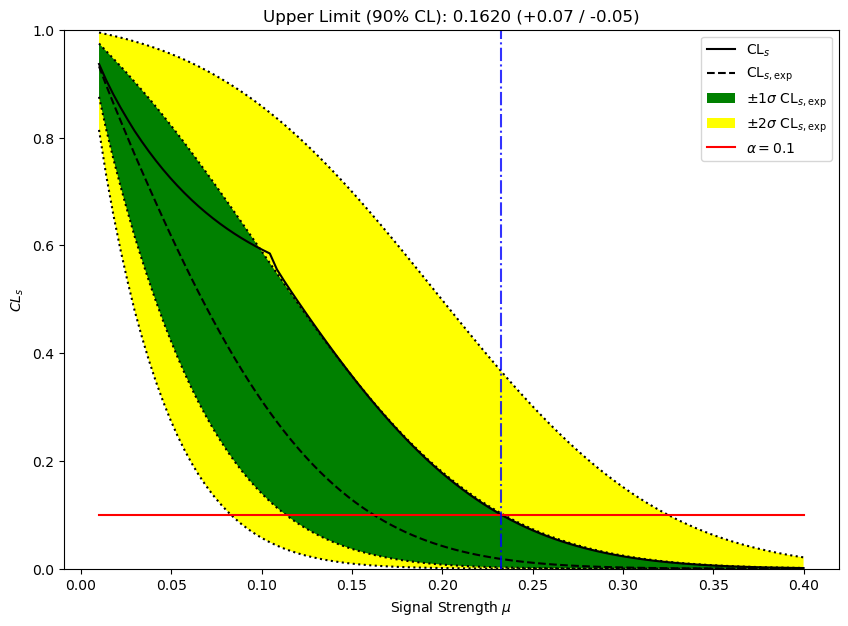

In [29]:
import numpy as np
import json
import pyhf
import matplotlib.pyplot as plt
from pyhf.contrib.viz import brazil


out_json = "/home/zhonghua/Filt_Event/UpperLimit/uncertainty/Transformer_baseline/model_with_free_bkg_ABCD.json"
# =====================================================
# 4. Calculate Upper Limit
# =====================================================
print("\n>>> Running Limit Calculation...")
try:
    with open(out_json, "r") as f:
            spec = json.load(f)
except FileNotFoundError:
    print("错误: 未找到 model.json")
    exit()
# Setup Minuit optimizer with robust settings
try:
    custom_optimizer = pyhf.optimize.minuit_optimizer(verbose=False, strategy=0, tolerance=1)
    pyhf.set_backend("numpy", custom_optimizer)
except ImportError:
    print("Warning: iminuit not installed, using scipy backend.")

workspace = pyhf.Workspace(spec)
model = workspace.model()
observations = workspace.data(model)

# Relax bounds for systematics to prevent fit failures
init_pars = model.config.suggested_init()
par_bounds = model.config.suggested_bounds()
poi_index = model.config.poi_index

new_bounds = []
for i, bounds in enumerate(par_bounds):
    if i == poi_index:
        new_bounds.append(bounds) # Keep mu bounds
    else:
        new_bounds.append([-10.0, 10.0]) # Relax nuisance bounds

# 1. Perform Fit (Check background normalization)
print("Performing MLE Fit...")
best_fit_pars = pyhf.infer.mle.fit(observations, model, par_bounds=new_bounds)
param_dict = dict(zip(model.config.par_order, best_fit_pars))
print(f"Fit Result - mu_bkg: {param_dict.get('mu_bkg', 1.0):.4f}")

# 2. Compute CLs Limits
print("Computing CLs Upper Limits...")
poi_values = np.linspace(0.01, 0.4, 100) # Adjust range based on sensitivity
try:
    results = pyhf.infer.intervals.upper_limits.upper_limit(
        observations, model, poi_values, level=0.1, return_results=True, par_bounds=new_bounds
    )
    obs_limit, exp_limits = results[0], results[1]
    
    # Calculate Flux Limit (assuming 'mu' scales the signal yield)
    # Flux Limit = (Limit_mu) * (Reference Flux)
    # Since sig_nom corresponds to your simulated flux (say 1e-13), multiply accordingly.
    
    print("\n" + "="*40)
    print(f"90% CL Upper Limit on mu:")
    print(f"  Observed: {obs_limit:.4f}")
    print(f"  Expected: {exp_limits[2]:.4f} (+{exp_limits[3]-exp_limits[2]:.2f} / -{exp_limits[2]-exp_limits[1]:.2f})")
    print("="*40 + "\n")
    
    # 3. Brazil Plot
    hypo_results = [
        pyhf.infer.hypotest(mu, observations, model, return_expected_set=True, test_stat="qtilde", par_bounds=new_bounds)
        for mu in poi_values
    ]
    
    fig, ax = plt.subplots(figsize=(10, 7))
    brazil.plot_results(poi_values, hypo_results, ax=ax, test_size=0.1)
    
    if not np.isnan(obs_limit):
        ax.axvline(obs_limit, color='blue', linestyle='-.', alpha=0.8, label=f'Obs. Limit ($\mu$={obs_limit:.4f})')
    plt.xlabel(r"Signal Strength $\mu$")
    plt.ylabel("$CL_s$")
    plt.title(f"Upper Limit (90% CL): {exp_limits[2]:.4f} (+{exp_limits[3]-exp_limits[2]:.2f} / -{exp_limits[2]-exp_limits[1]:.2f})")
    plt.show()

except Exception as e:
    print(f"Limit calculation failed: {e}")


In [ ]:
exp_limits


[array(0.09080225),
 array(0.12467491),
 array(0.1790721),
 array(0.26005685),
 array(0.36246451)]

>>> Calculating Flux Model Systematics (Gaisser vs Hörandel)...


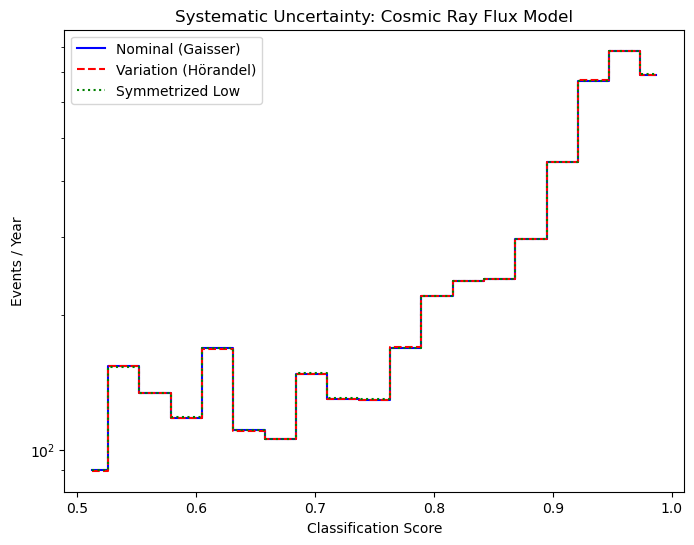

Total Yield (Gaisser): 5041.29
Total Yield (Hörandel): 5040.68
Difference: -0.01%


In [14]:
# =====================================================
# A. 计算流强模型带来的差异 (Flux Model Systematics)
# =====================================================
print(">>> Calculating Flux Model Systematics (Gaisser vs Hörandel)...")

# 1. 确保 DataFrame 里有 horandel_weight
# 如果之前的代码丢掉了这个列，你需要重新 merge 或者赋值回去
# 假设 bkg_train_final 已经有了 'horandel_weight'
if 'horandel_weight' not in bkg_train_final.columns:
    raise ValueError("DataFrame 中缺少 'horandel_weight' 列，请在准备数据时保留该列！")

# 2. 生成基准直方图 (Gaisser - 已有)
# bkg_nom = get_counts(bkg_train_final, 'mlp_score', 'gaisser_weight', BINS) # 之前算过了

# 3. 生成变动直方图 (Hörandel)
# 注意：Score 不变，只变 Weight
bkg_horandel = get_counts(bkg_train_final, 'mlp_score', 'horandel_weight', BINS, scaled_num=num_dict['bkg_nom'])

# 4. (可选) 归一化处理
# 因为你的模型里已经有了 mu_bkg (Free Floating)，它会自动处理整体的归一化差异。
# 我们主要关心的是 "形状 (Shape)" 的差异。
# 为了让 histosys 更纯粹地反映形状变化，有时会将 Hörandel 归一化到 Gaisser 的总数。
# 但在 pyhf 中，直接放进去通常也没问题，mu_bkg 会处理剩下的部分。
# 这里我们选择：直接使用原始权重的 Hörandel，保留其形状和归一化的双重影响。

# 5. 定义 High / Low 变动
# 只有两种模型，通常把 Hörandel 当作 "High Variation"
sys_flux_hi = bkg_horandel

# 构造 "Low Variation"
# 方法：对称化误差 (Symmetrization)。
# 如果 Hörandel 在某 bins 比 Gaisser 高 10%，那么 Low 就比 Gaisser 低 10%。
# 公式: Low = Nominal - (High - Nominal) = 2 * Nominal - High
sys_flux_lo = 2 * bkg_nom - sys_flux_hi

# 保护：防止出现负数
sys_flux_lo = np.maximum(sys_flux_lo, 0)

# =====================================================
# B. 画图检查 (这一步很重要！)
# =====================================================
plt.figure(figsize=(8,6))
centers = (BINS[:-1] + BINS[1:]) / 2
plt.step(centers, bkg_nom, where='mid', label='Nominal (Gaisser)', color='blue')
plt.step(centers, sys_flux_hi, where='mid', label='Variation (Hörandel)', linestyle='--', color='red')
plt.step(centers, sys_flux_lo, where='mid', label='Symmetrized Low', linestyle=':', color='green')
plt.title("Systematic Uncertainty: Cosmic Ray Flux Model")
plt.xlabel("Classification Score")
plt.ylabel("Events / Year")
plt.yscale('log')
plt.legend()
plt.show()

# 打印一下总数的差异，心里有底
print(f"Total Yield (Gaisser): {np.sum(bkg_nom):.2f}")
print(f"Total Yield (Hörandel): {np.sum(bkg_horandel):.2f}")
diff_pct = (np.sum(bkg_horandel) - np.sum(bkg_nom)) / np.sum(bkg_nom) * 100
print(f"Difference: {diff_pct:.2f}%")



>>> Generating Energy Scale Systematics...
[      Bkg Nom       ] Cut: E[1.90, 2.10], Rue<-2.00 | Events: 181 | Yield: 715443.58
[      Bkg E_Up      ] Cut: E[1.99, 2.21], Rue<-2.00 | Events: 85 | Yield: 295592.15
[     Bkg E_Down     ] Cut: E[1.80, 1.99], Rue<-2.00 | Events: 96 | Yield: 419851.43
[      Sig Nom       ] Cut: E[1.90, 2.10], Rue<-2.00 | Events: 53802 | Yield: 493.32
[      Sig E_Up      ] Cut: E[1.99, 2.21], Rue<-2.00 | Events: 37545 | Yield: 337.18
[     Sig E_Down     ] Cut: E[1.80, 1.99], Rue<-2.00 | Events: 16257 | Yield: 156.14

>>> Generating Rue Scale Systematics...
[   Bkg Rue_Tight    ] Cut: E[1.90, 2.10], Rue<-2.05 | Events: 142 | Yield: 560799.11
[   Bkg Rue_Loose    ] Cut: E[1.90, 2.10], Rue<-1.95 | Events: 257 | Yield: 1011777.64
[   Sig Rue_Tight    ] Cut: E[1.90, 2.10], Rue<-2.05 | Events: 53802 | Yield: 493.32
[   Sig Rue_Loose    ] Cut: E[1.90, 2.10], Rue<-1.95 | Events: 53802 | Yield: 493.32

>>> Extracting Observed Data...
[      Observed      ] Cut: 

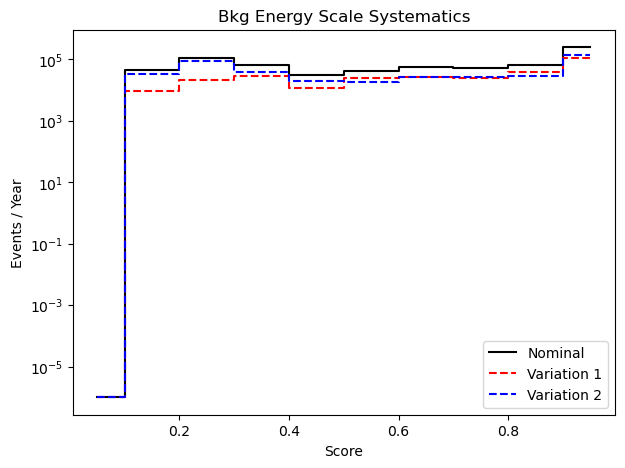

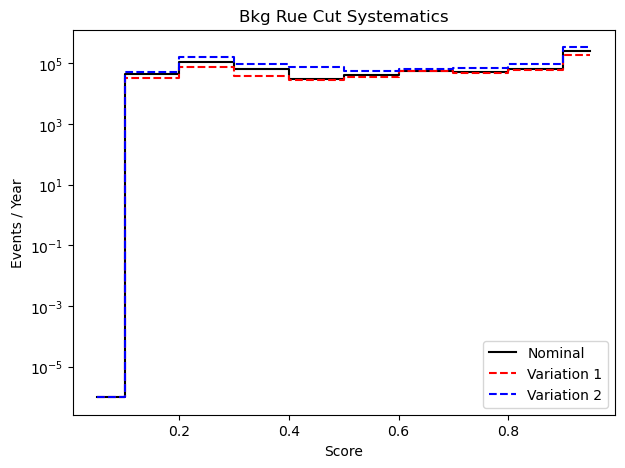

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# 0. 全局配置
# ==========================================
# 之前训练好的 score 列名 (如果没有请先运行 predict)
SCORE_COL = 'mlp_score' 

# 物理切选的标准值 (Nominal Cuts)
CUT_E_MIN = 1.9
CUT_E_MAX = 2.1
CUT_RUE_MAX = -2
CUT_RHO_MIN = 0   # 假设 rho40 > 0 (如果有的话)

# 系统误差幅度
UNCERTAINTY_E = 0.05    # 能量标度误差 ±5%
UNCERTAINTY_RUE = 0.05  # Rue 绝对偏移 ±0.05

# 目标直方图 Bins
BINS = np.linspace(0, 1, 11)

# ==========================================
# 1. 定义动态切选函数
# ==========================================
def get_hist_with_cuts(df, weight_col, e_scale=1.0, rue_shift=0.0, label=""):
    """
    df: 全量大范围数据 (bkg_train_final 或 sig_train_final)
    e_scale: 能量标度因子 (1.0=Nominal, 1.05=Up, 0.95=Down)
    rue_shift: Rue阈值偏移 (0.0=Nominal, -0.05=Tight, +0.05=Loose)
    """
    # 1. 计算变动后的 Cut 阈值
    # E Scale Up 意味着探测器测到的能量偏高，所以相同的物理Cut对应更大的数值
    # 或者理解为：我们移动窗口来探测 "Scale变化" 的影响
    c_e_min = CUT_E_MIN * e_scale
    c_e_max = CUT_E_MAX * e_scale
    
    # Rue Shift: 负数越小越严。
    # Shift < 0 -> Cut 变小 -> 变严 (Tight)
    # Shift > 0 -> Cut 变大 -> 变松 (Loose)
    c_rue = CUT_RUE_MAX + rue_shift
    
    # 2. 应用切选
    # 注意：这里我们使用原始的 recE 和 R_ue 列进行筛选
    cond = (df['recE'] > c_e_min) & (df['recE'] < c_e_max) & \
           (df['R_ue'] < c_rue) 
           # & (df['rho40'] > CUT_RHO_MIN) # 如果有 rho40 请取消注释
            
    df_cut = df[cond].copy()
    
    # 3. 统计直方图
    if len(df_cut) == 0:
        return np.full(len(BINS)-1, 1e-6)
    
    scores = df_cut[SCORE_COL].values
    weights = df_cut[weight_col].values
    
    counts, _ = np.histogram(scores, bins=BINS, weights=weights)
    
    # 归一化到年 (如果权重是率)
    counts = counts * 365 * 86400
    
    # 打印调试信息
    print(f"[{label:^20}] Cut: E[{c_e_min:.2f}, {c_e_max:.2f}], Rue<{c_rue:.2f} | Events: {len(df_cut)} | Yield: {counts.sum():.2f}")
    
    return np.maximum(counts, 1e-6)

# ==========================================
# 2. 检查 Score 是否存在
# ==========================================
# 这一步很关键：系统误差是基于 "通过Cut的事例的Score分布"
# 所以 bkg_train_final 和 sig_train_final 必须已经有了 'mlp_score' 列
# 如果没有，请先用你的 manager 对它们进行预测！
if SCORE_COL not in bkg_train_final.columns:
    print("正在对 bkg_train_final 进行打分...")
    # 假设 manager 是之前训练好的
    bkg_train_final[SCORE_COL] = manager.predict_ensemble(bkg_train_final) 

if SCORE_COL not in sig_train_final.columns:
    print("正在对 sig_train_final 进行打分...")
    sig_train_final[SCORE_COL] = manager.predict_ensemble(sig_train_final)

# ==========================================
# 3. 生成 recE 系统误差 (Energy Scale)
# ==========================================
print("\n>>> Generating Energy Scale Systematics...")

# 背景 (Proton)
bkg_nom = get_hist_with_cuts(bkg_train_final, 'gaisser_weight', label="Bkg Nom")
bkg_e_up = get_hist_with_cuts(bkg_train_final, 'gaisser_weight', e_scale=1+UNCERTAINTY_E, label="Bkg E_Up")
bkg_e_down = get_hist_with_cuts(bkg_train_final, 'gaisser_weight', e_scale=1-UNCERTAINTY_E, label="Bkg E_Down")

# 信号 (Monopole) - 信号对能量 Cut 极其敏感
sig_nom = get_hist_with_cuts(sig_train_final, 'weight', label="Sig Nom")
sig_e_up = get_hist_with_cuts(sig_train_final, 'weight', e_scale=1+UNCERTAINTY_E, label="Sig E_Up")
sig_e_down = get_hist_with_cuts(sig_train_final, 'weight', e_scale=1-UNCERTAINTY_E, label="Sig E_Down")

# ==========================================
# 4. 生成 R_ue 系统误差 (Rue Scale/Resolution)
# ==========================================
print("\n>>> Generating Rue Scale Systematics...")

# 背景
bkg_rue_up = get_hist_with_cuts(bkg_train_final, 'gaisser_weight', rue_shift=-UNCERTAINTY_RUE, label="Bkg Rue_Tight") # 变严
bkg_rue_down = get_hist_with_cuts(bkg_train_final, 'gaisser_weight', rue_shift=+UNCERTAINTY_RUE, label="Bkg Rue_Loose") # 变松

# 信号
# Rue 的微小变动对信号影响通常较小（因为信号在 -8 很深的位置），但为了完整性也要算
sig_rue_up = get_hist_with_cuts(sig_train_final, 'weight', rue_shift=-UNCERTAINTY_RUE, label="Sig Rue_Tight")
sig_rue_down = get_hist_with_cuts(sig_train_final, 'weight', rue_shift=+UNCERTAINTY_RUE, label="Sig Rue_Loose")

# ==========================================
# 5. 生成 Observation (Exp Data)
# ==========================================
# 实验数据不做变动，只应用 Nominal Cut
print("\n>>> Extracting Observed Data...")
# 确保 exp 数据在 -1.9 处被截断不会影响 -2.6 的分析
obs_hist = get_hist_with_cuts(exp_final, 'weight', label="Observed")

# ==========================================
# 6. 可视化检查 (可选)
# ==========================================
def plot_sys_check(nom, up, down, title):
    plt.figure(figsize=(7, 5))
    x = (BINS[:-1] + BINS[1:]) / 2
    plt.step(x, nom, where='mid', label='Nominal', color='black')
    plt.step(x, up, where='mid', label='Variation 1', linestyle='--', color='red')
    plt.step(x, down, where='mid', label='Variation 2', linestyle='--', color='blue')
    plt.yscale('log')
    plt.title(title)
    plt.legend()
    plt.xlabel("Score")
    plt.ylabel("Events / Year")
    plt.show()

plot_sys_check(bkg_nom, bkg_e_up, bkg_e_down, "Bkg Energy Scale Systematics")
plot_sys_check(bkg_nom, bkg_rue_up, bkg_rue_down, "Bkg Rue Cut Systematics")
